In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 16}
matplotlib.rc('font', **font)

In [2]:
def evalGovindjee(F, C_i_inv, dt):
    #Material parameters for Vulcanized rubber (Ogden material for neq):
    mu_m = np.array([51.4, -18, 3.86])
    alpha_m = np.array([1.8, -2, 7])
    K_m = 10000
    tau = 17.5
    shear_mod = 1/2*(mu_m[0]*alpha_m[0] + mu_m[1]*alpha_m[1] + mu_m[2]*alpha_m[2])
    eta_D = tau*shear_mod
    eta_V = tau*K_m
    #Neo Hookean for eq parts:
    mu = shear_mod #same as mu for neq parts for simplicity.
    K = K_m

    be_trial = np.einsum('ij,jk,kl->il', F, C_i_inv, F.transpose())
    lamb_e_trial, n_A = np.linalg.eig(be_trial)
    lamb_e_trial = np.sqrt(np.real(lamb_e_trial))
    eps_e_trial = np.log(lamb_e_trial)
    
    #Initial guess for eps_e
    eps_e = eps_e_trial
    normres = 1
    iter = 0
    itermax = 20
    
    while normres>1.e-6 and iter < itermax:
        lamb_e = np.exp(eps_e)
        Je = lamb_e[0]*lamb_e[1]*lamb_e[2]
        bbar_e = Je**(-2/3)*lamb_e**2 #(54)
        #Calculate K_AB
        ddevtau_AdepsBe = np.zeros([3,3])
        for A in range(3):
            for B in range(3):
                if A==B:
                    for r in range(3):
                        oi = np.array([0,1,2]) #Other indices. Indices other than A=B
                        oi = np.delete(oi, A)
                        ddevtau_AdepsBe[A,B]+= mu_m[r]*alpha_m[r]*(4/9*bbar_e[A]**(alpha_m[r]/2) + 1/9*bbar_e[oi[0]]**(alpha_m[r]/2)
                                                                   + 1/9*bbar_e[oi[1]]**(alpha_m[r]/2)) #(B12)
                else:
                    for r in range(3):
                        oi = np.array([0,1,2]) #Other index. Index other than A or B.
                        oi = np.delete(oi, [A,B])
                        ddevtau_AdepsBe[A,B]+= mu_m[r]*alpha_m[r]*(-2/9*bbar_e[A]**(alpha_m[r]/2) - 2/9*bbar_e[B]**(alpha_m[r]/2)
                                                                   + 1/9*bbar_e[oi[0]]**(alpha_m[r]/2)) #(B13)
        
        
        K_AB = np.eye(3) + dt/2/eta_D*ddevtau_AdepsBe - dt/3/eta_V*K_m*Je**2*np.ones([3,3]) #(B15)
        
        K_AB_inv = np.linalg.inv(K_AB)

        devtau = np.zeros(3)
        for A in range(3):
            for r in range(3):
                oi = np.array([0,1,2])
                oi = np.delete(oi, A)
                devtau[A]+= mu_m[r]*(2/3*bbar_e[A]**(alpha_m[r]/2) - 1/3*bbar_e[oi[0]]**(alpha_m[r]/2) - 1/3*bbar_e[oi[1]]**(alpha_m[r]/2)) #(B8)
        tau_NEQdyadicI = 3/2*K_m*(Je**2-1) #(B8)
        
        res = eps_e + dt*(1/2/eta_D*devtau + 1/9/eta_V*tau_NEQdyadicI*np.ones(3))-eps_e_trial #(60), res=r in the paper
        deps_e = np.einsum('ij,j->i', K_AB_inv, -res)
        eps_e = eps_e + deps_e
        normres = np.linalg.norm(res)
        iter+= 1

    #Now we have the value of eps_e
    #Calculate tau_NEQ
    lamb_e = np.exp(eps_e)
    Je = lamb_e[0]*lamb_e[1]*lamb_e[2]
    bbar_e = Je**(-2/3)*lamb_e**2
    devtau = np.zeros(3)
    for A in range(3):
        for r in range(3):
            oi = np.array([0,1,2])
            oi = np.delete(oi, A)
            devtau[A]+= mu_m[r]*(2/3*bbar_e[A]**(alpha_m[r]/2) - 1/3*bbar_e[oi[0]]**(alpha_m[r]/2) - 1/3*bbar_e[oi[1]]**(alpha_m[r]/2)) #(B8)
    tau_NEQdyadicI = 3*K_m/2*(Je**2-1) #(B8)
    tau_A = devtau + 1/3*tau_NEQdyadicI #(B8)
    tau_NEQ = np.einsum('i,ji,ki->jk', tau_A, n_A, n_A) #(58)
    tr_tau = np.trace(tau_NEQ)
    
    be = np.einsum('i,ji,ki->jk', lamb_e**2, n_A, n_A)
    F_inv = np.linalg.inv(F)
    C_i_inv_new = np.einsum('ij,jk,kl->il', F_inv, be, F_inv.transpose())
    
    J = np.linalg.det(F)
    b = np.einsum('ij,kj->ik', F, F)
    sigma_EQ = mu/J*(b-np.eye(3)) + 2*K*(J-1)*np.eye(3) #neo Hookean material
    sigma = 1/Je*tau_NEQ + sigma_EQ #(7)
    return sigma, C_i_inv_new, lamb_e

In [3]:
# uniaxial tension 
# epsilon_x(t)
# sigma_y, sigma_z
nsteps = 100
dt = 1
F_vec = np.zeros((nsteps,3,3))
C_i_inv_vec = np.zeros((nsteps,3,3))
sigma_x_vec = np.zeros((nsteps))
sigma_y_vec = np.zeros((nsteps))
sigma_z_vec = np.zeros((nsteps))
epsilon_xv_vec = np.zeros((nsteps))
lamb_e_vec = np.zeros((nsteps,3))
# initial condition for viscous strains 
epsilon_v = np.zeros((6))
C_i_inv = np.eye(3)
for i in range(nsteps):
    if i<50:
        epsilon_x = i/nsteps+1e-6
    else:
        epsilon_x = 0.5
    sigma_y = 0
    sigma_z = 0
    normres = 1
    iter=0
    itermax = 20
    epsilon_y = 0
    epsilon_z = 0
    eta = 10
    while normres>1e-6 and iter<itermax:
        # guess for F
        F = np.array([[1+epsilon_x, 0, 0], [0, 1+epsilon_y, 0], [0, 0, 1+epsilon_z]])
        #print(F)
        # GIVEN F and C_i_inv from previous time, compute stress and new C_i_inv
        sigma, C_i_inv_new, lamb_e = evalGovindjee(F, C_i_inv, dt)
        res = np.array([sigma[1,1]-sigma_y, sigma[2,2]-sigma_z])

        # calculate dres with NR 
        F_py = np.array([[1+epsilon_x, 0, 0], [0, 1+epsilon_y+1e-6, 0], [0, 0, 1+epsilon_z]])
        sigma_py,aux, aux2 = evalGovindjee(F_py, C_i_inv, dt)
        F_pz = np.array([[1+epsilon_x, 0, 0], [0, 1+epsilon_y, 0], [0, 0, 1+epsilon_z+1e-6]])
        sigma_pz,aux, aux2 = evalGovindjee(F_pz, C_i_inv, dt)
        dres = np.array([[(sigma_py[1,1]-sigma[1,1])/1e-6,(sigma_py[2,2]-sigma[2,2])/1e-6],\
                        [(sigma_pz[1,1]-sigma[1,1])/1e-6,(sigma_pz[2,2]-sigma[2,2])/1e-6]])
        deps = np.linalg.solve(dres,-res)
        epsilon_y += deps[0]
        epsilon_z += deps[1]
        normres = np.linalg.norm(res)
        iter+=1 

    # update the internal variable at end of iterations 
    C_i_inv = C_i_inv_new
    F_vec[i] = F
    sigma_x_vec[i] = sigma[0,0]
    sigma_y_vec[i] = sigma[1,1]
    sigma_z_vec[i] = sigma[2,2]
    C_i_inv_vec[i] = C_i_inv
    lamb_e_vec[i] = lamb_e

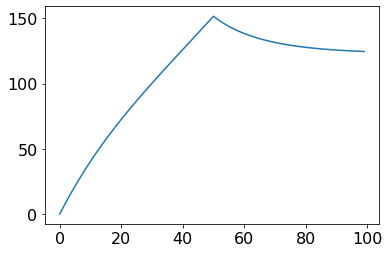

In [4]:
plt.plot(sigma_x_vec)

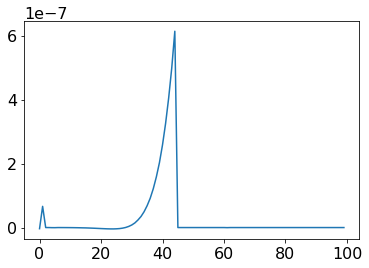

In [6]:
plt.plot(sigma_z_vec)